In [1]:
import numpy as np
import pydicom
import matplotlib.pyplot as plt
import matplotlib as mpl
import imageio
from scipy import interpolate
from scipy import optimize
from scipy.signal import convolve
from skimage.filters import gaussian
plt.style.use(['science', 'notebook'])
import tomopy
import functions
import pandas as pd
import json

from scipy.interpolate import RectBivariateSpline
from skimage.data import shepp_logan_phantom
from skimage.transform import radon, iradon, rescale, rotate
from skimage.measure import profile_line

def get_gaus_kernel(n, sig):
    xv, yv = np.meshgrid(np.arange(n), np.arange(n))
    xv = xv - xv.max()/2
    yv = yv -  yv.max()/2
    gaus_kernel = 1/np.sqrt(2*np.pi*sig**2) * np.exp(-(xv**2+yv**2)/(2*sig**2))
    return gaus_kernel/gaus_kernel.sum()

Define mean of Poisson distribution and dimensions of image

In [2]:
lam = 500
n = 400
L_val = 1/2
B_val = 1/5

Read original CT image and normalize to get reasonable attenuation coefficient $\mu(x,y)$

In [3]:
A1 = imageio.imread('images/phantom1.png').sum(axis=2)
A2 = imageio.imread('images/phantom2.png').sum(axis=2)
A3 = imageio.imread('images/phantom3.png').sum(axis=2)
A4 = imageio.imread('images/phantom4.png').sum(axis=2)
A1_norm = functions.normalize_phantom(A1)
A2_norm = functions.normalize_phantom(A2)
A3_norm = functions.normalize_phantom(A3)
A4_norm = functions.normalize_phantom(A4)

A = A1
A_norm = A1_norm

Get all tumours and append to single array

In [4]:
Ts = np.array([np.asarray(imageio.imread(f'images/t{i}.png').sum(axis=2) > 0) for i in range(1,24)])
n = A1.shape[0]
T = Ts.sum(axis=0).astype(bool)
T_masked = np.ma.masked_where(~T, T)

Add live and background and remove any overlapping tumours from liver

In [5]:
L = np.asarray(imageio.imread(f'images/liv.png').sum(axis=2))>260
B = np.asarray(imageio.imread(f'images/background.png').sum(axis=2))>260

Ts_non_overlap = []
for T in Ts:
    if not np.any(T*L):
        Ts_non_overlap.append(T)
T = np.array(Ts_non_overlap).sum(axis=0).astype(bool)
T_masked = np.ma.masked_where(~T, T)
B = B^(T+L)

In [6]:
T_masked = np.ma.masked_where(~T, T)
L_masked = np.ma.masked_where(~L, L)
B_masked = np.ma.masked_where(~B, B)
masks = [T_masked, L_masked, B_masked]
mask_names = ['T', 'L', 'B']

Get tumour distribution by smoothing the activity.

In [7]:
U = functions.get_tumour_dist(T, sigma=3)
U[L] += L_val
U[B] += B_val

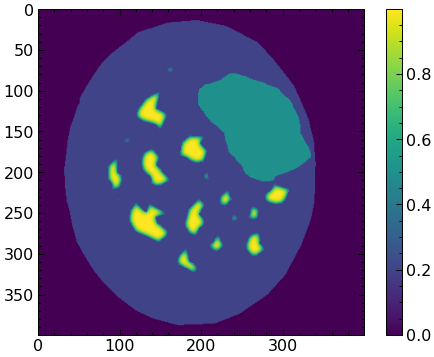

In [8]:
plt.imshow(U)
plt.colorbar()

Get original PET image along with decay points $(x,y)$ and corresponding decay angles $\theta$.

In [9]:
''' Only run first time '''
#PET_og, dpoints, dangles = functions.get_original_PET(U, T+L+B, lam=lam)
#prob_of_detections1 = functions.compute_prob_of_detections(A1_norm, dpoints, dangles, n=A1.shape[0])
#np.savez("tumour_dist_P1_livback.npz", PET_og=PET_og, dpoints=dpoints, dangles=dangles, prob_of_detections=prob_of_detections1)
#prob_of_detections2 = functions.compute_prob_of_detections(A2_norm, dpoints, dangles, n=A1.shape[0])
#np.savez("tumour_dist_P2_livback.npz", PET_og=PET_og, dpoints=dpoints, dangles=dangles, prob_of_detections=prob_of_detections2)
#prob_of_detections3 = functions.compute_prob_of_detections(A3_norm, dpoints, dangles, n=A1.shape[0])
#np.savez("tumour_dist_P3_livback.npz", PET_og=PET_og, dpoints=dpoints, dangles=dangles, prob_of_detections=prob_of_detections3)
#prob_of_detections4 = functions.compute_prob_of_detections(A4_norm, dpoints, dangles, n=A1.shape[0])
#np.savez("tumour_dist_P4_livback.npz", PET_og=PET_og, dpoints=dpoints, dangles=dangles, prob_of_detections=prob_of_detections4)
dfile = np.load('tumour_dist_P1_livback.npz')
PET_og, dpoints, dangles, prob_of_detections = dfile['PET_og'], dfile['dpoints'], dfile['dangles'], dfile['prob_of_detections']

Get the attenuated PET image by removing certain events according to their probability of attenuation

In [10]:
PET_att, mask_att = functions.get_attenuated_PET(dpoints, dangles, prob_of_detections, n=n)

Get corresponding sinograms

In [11]:
sino, rs, thetas =  functions.get_sinogram(dpoints, dangles)
sino_att, _, _ =  functions.get_sinogram(dpoints, dangles, mask=mask_att)

# Reconstruction

Get a matrix that gives the probability of an event being detected for each $(x,y)$ value

In [337]:
def estimate_prob_of_detections_rtheta(rs, thetas, A, num=1000):
    n = A.shape[0]
    diameter = np.sqrt(2*n**2)
    # from histogram edges to centers
    thetas = thetas[:-1]+np.diff(thetas)[0]/2
    rs = rs[:-1]+0.5
    print(len(rs))
    prob_of_detections = np.zeros([len(rs),len(thetas)])
    for i,r in enumerate(rs):
        for j,theta in enumerate(thetas):
            x = r*np.cos(theta+np.pi/2) + n//2
            y = r*np.sin(theta+np.pi/2) + n//2
            x1 = x - np.cos(theta)* diameter
            x2 =  x + np.cos(theta)* diameter
            y1 = y - np.sin(theta)* diameter
            y2 =  y + np.sin(theta)* diameter
            xx = np.linspace(x1, x2, num)
            yy = np.linspace(y1, y2, num)
            mask = (xx>0) * (xx<n) * (yy>0) * (yy<n)
            xx = xx[mask].astype(int)
            yy = yy[mask].astype(int)
            dL = 2*diameter / num
            prob_of_detections[i][j] = np.exp(-A[xx,yy].sum()*dL)
    return prob_of_detections

Get the reconstructed PET image corresponding to the sinogram

In [338]:
sino_prob = estimate_prob_of_detections_rtheta(rs, thetas, A_norm, num=1000)

400


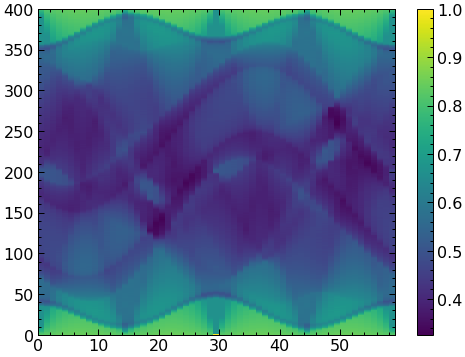

In [339]:
plt.pcolormesh(sino_prob)
plt.colorbar()

In [342]:
#PET_att_recon_GRIDREC = functions.compute_recon_tomopy(sino_att, thetas, 'gridrec', filter_name='hanning')
#PET_att_recon_MLEM = functions.compute_recon_tomopy(sino_att, thetas, 'mlem', num_iter=40)
#PET_att_recon_BART = functions.compute_recon_tomopy(sino_att, thetas, 'bart', num_iter=100)
PET_att_recon_ART = functions.compute_recon_tomopy(sino_att/sino_prob, thetas, 'bart', num_iter=15)

Reconstructing 1 slice groups with 1 master threads...


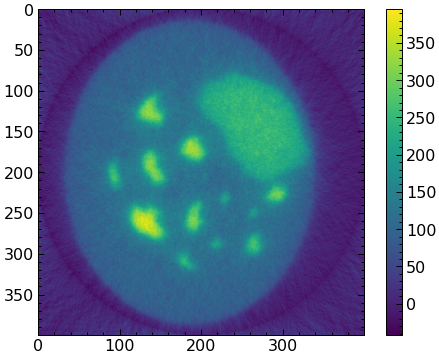

In [343]:
plt.imshow(PET_att_recon_ART)
plt.colorbar()

In [244]:
%%capture
MSEs_MLEM = functions.MSE_tomopy(sino_att, thetas, PET_att, T_masked, det_matrix, 'mlem', num_iter=10)
MSEs_BART = functions.MSE_tomopy(sino_att, thetas, PET_att, T_masked, det_matrix, 'bart', num_iter=10)
MSEs_ART  = functions.MSE_tomopy(sino_att, thetas, PET_att, T_masked, det_matrix, 'art', num_iter=10)

TypeError: MSE_tomopy() got multiple values for argument 'num_iter'

In [110]:
n_iters, MSEs  = functions.MSE_tomopy(sino_att, thetas, PET_og, T_masked,
                                    'tikh', num_iter=10, det_matrix=det_matrix, every_n=2)

Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...


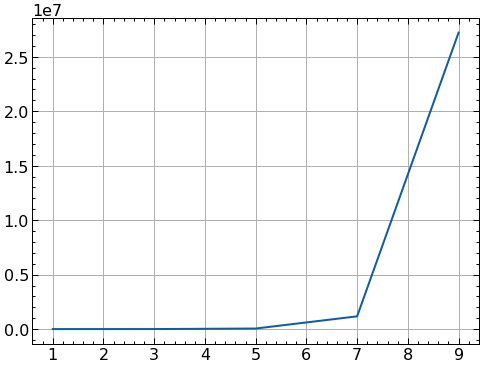

In [111]:
plt.plot(n_iters, np.sqrt(MSEs))
plt.grid()

Normalize this PET image based on the probability of certain events being detected.

In [18]:
PET_recon = PET_att_recon_MLEM/ det_matrix
PET_recon_smoothed = convolve(PET_recon, get_gaus_kernel(9,1), mode='same')

In [ ]:
psf_recon = functions.compute_recon_tomopy(sino_psf, thetas_psf, 'osem', num_iter=30)

In [ ]:
plt.figure(figsize=(12,5))
plt.hist(PET_og[T].ravel(), color='blue', histtype='step', bins=20, label='Original')
plt.axvline(PET_og[T].mean(), color='blue', ls='--')
plt.hist(PET_att[T].ravel(), color='orange', histtype='step', bins=20, label='Attenuated')
plt.axvline(PET_att[T].mean(), color='orange', ls='--')
plt.hist(PET_att_recon[T].ravel(), color='green', histtype='step', bins=20, label='Recon [raw]')
plt.axvline(PET_att_recon[T].mean(), color='green', ls='--')
plt.hist(PET_recon[T].ravel(), color='red',  histtype='step', bins=20, label='Recon [adjusted]')
plt.axvline(PET_recon[T].mean(), color='red', ls='--')
plt.legend()
plt.show()

In [186]:
PET_recon_filtered = gaussian(PET_recon, sigma=0.9)

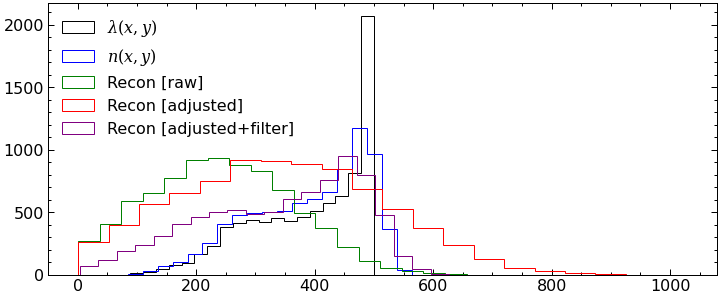

In [187]:
plt.figure(figsize=(12,5))
plt.hist(500*U[T].ravel(), color='black', histtype='step', bins=20, label='$\lambda(x,y)$')
plt.hist(PET_og[T].ravel(), color='blue', histtype='step', bins=20, label='$n(x,y)$')
plt.hist(PET_att_recon[T].ravel(), color='green', histtype='step', bins=20, label='Recon [raw]')
plt.hist(PET_recon[T].ravel(), color='red',  histtype='step', bins=20, label='Recon [adjusted]')
plt.hist(PET_recon_filtered[T].ravel(), color='purple',  histtype='step', bins=20, label='Recon [adjusted+filter]')
plt.legend(loc='upper left')
plt.show()

In [277]:
lam = 500*U[T].ravel()
n = PET_og[T].ravel()
nD = PET_att_recon[T].ravel()
n_hat_raw = PET_recon[T].ravel()

# Fitler
PET_recon_filtered = gaussian(PET_recon, sigma=2)
n_hat_filt = PET_recon_filtered[T].ravel()

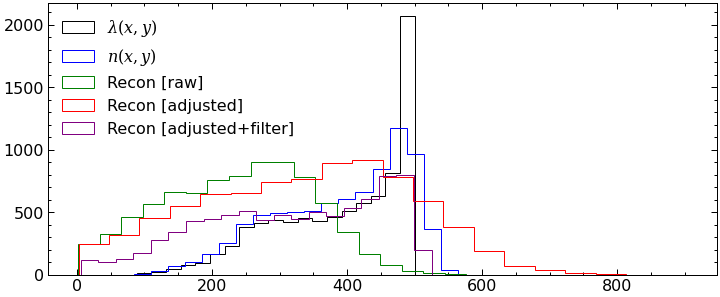

In [278]:
plt.figure(figsize=(12,5))
plt.hist(500*U[T].ravel(), color='black', histtype='step', bins=20, label='$\lambda(x,y)$')
plt.hist(PET_og[T].ravel(), color='blue', histtype='step', bins=20, label='$n(x,y)$')
plt.hist(PET_att_recon[T].ravel(), color='green', histtype='step', bins=20, label='Recon [raw]')
plt.hist(PET_recon[T].ravel(), color='red',  histtype='step', bins=20, label='Recon [adjusted]')
plt.hist(PET_recon_filtered[T].ravel(), color='purple',  histtype='step', bins=20, label='Recon [adjusted+filter]')
plt.legend(loc='upper left')
plt.show()

In [190]:
from skimage import color, data, restoration

In [191]:
def get_gaus_kernel(n, sig):
    xv, yv = np.meshgrid(np.arange(n), np.arange(n))
    xv = xv - xv.max()/2
    yv = yv -  yv.max()/2
    gaus_kernel = 1/np.sqrt(2*np.pi*sig**2) * np.exp(-(xv**2+yv**2)/(2*sig**2))
    return gaus_kernel/gaus_kernel.sum()
    

In [192]:
g = get_gaus_kernel(10, 5)
new = restoration.wiener(PET_recon, g, 1, clip=False)

In [193]:
n_hat_deconv = new[T].ravel()

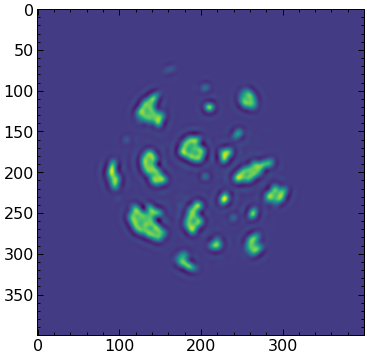

In [194]:
plt.imshow(new)

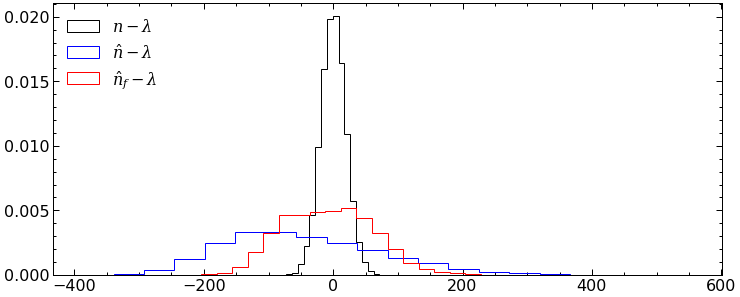

In [195]:
plt.figure(figsize=(12,5))
plt.hist(n-lam, color='black', histtype='step', bins=20, label='$n-\lambda$', density=True)
plt.hist(n_hat_raw-lam, color='blue', histtype='step', bins=20, label='$\hat{n}-\lambda$', density=True)
plt.hist(n_hat_deconv-lam, color='red', histtype='step', bins=20, label='$\hat{n}_{f}-\lambda$', density=True)
#plt.hist(PET_og[T].ravel(), color='blue', histtype='step', bins=20, label='$n(x,y)$')
plt.legend(loc='upper left')
plt.show()

In [196]:
def compute_SUV_max(PET_og, PET_recon_filtered, Ts):
    SUV_og = []
    SUV_recon_filtered = []
    tumour_size = []
    for T in Ts:
        tumour_size.append(T.sum())
        SUV_og.append(PET_og[T].max())
        SUV_recon_filtered.append(PET_recon_filtered[T].max())
    return np.array(tumour_size), np.array(SUV_og), np.array(SUV_recon_filtered)

def compute_SUV_mean(PET_og, PET_recon_filtered, Ts):
    SUV_og = []
    SUV_recon_filtered = []
    tumour_size = []
    for T in Ts:
        tumour_size.append(T.sum())
        SUV_og.append(PET_og[T].mean())
        SUV_recon_filtered.append(PET_recon_filtered[T].mean())
    return np.array(tumour_size), np.array(SUV_og), np.array(SUV_recon_filtered)

In [197]:
tumour_size, SUV_og_max, SUV_recon_max = compute_SUV_max(PET_og, new, Ts)
tumour_size, SUV_og_mean, SUV_recon_mean = compute_SUV_mean(PET_og, new, Ts)

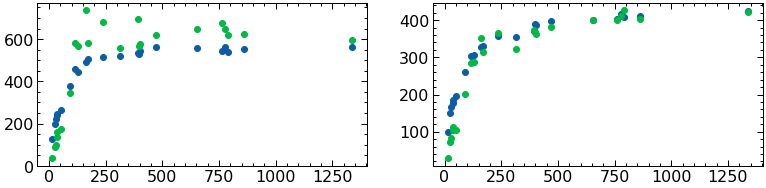

In [198]:
fig, ax = plt.subplots(1,2,figsize=(13,3))
ax[0].scatter(tumour_size, SUV_og_max)
ax[0].scatter(tumour_size, SUV_recon_max)
ax[1].scatter(tumour_size, SUV_og_mean)
ax[1].scatter(tumour_size, SUV_recon_mean)

# Results from All Algorithms

In [12]:
def get_iters_MSEs(df, name):
    iters = np.array(df[name][0].strip('][').replace('\n', '').split()).astype(float)
    MSE = np.array(df[name][1].strip('][').replace('\n', '').split()).astype(float)
    var = np.array(df[name][2].strip('][').replace('\n', '').split()).astype(float)
    bias = np.array(df[name][3].strip('][').replace('\n', '').split()).astype(float)
    iter_best = int(df[name][5])
    MSE_best = MSE[iters==iter_best][0]
    return iters, MSE, var, bias, MSE_best

def info_dict(df):
    algos = list(df.columns[1:])
    di = {}
    for algo in algos:
        iters, mses, var, bias, mse_best = get_iters_MSEs(df, algo)
        di[algo] = {'iters': iters, 'mses': mses, 'vars':var, 'bias':bias, 'mse_best': mse_best}

    rmse_best = []
    for algo in algos:
        rmse_best.append(np.sqrt(di[algo]['mse_best']))
    return algos, rmse_best, di

def info_dict_livback(df):
    algos = list(df.columns[1:])
    di = {}
    for algo in algos:
        iters = df[algo]['n_iter']
        mse_best = df[algo]['data']['T']['MSE']
        di[algo] = {'iters': iters, 'data': data, 'mse_best': mse_best}

    rmse_best = []
    for algo in algos:
        rmse_best.append(np.sqrt(di[algo]['data']['T']['mse_best']))
    return algos, rmse_best, di

In [13]:
df1 = pd.read_pickle('all_algos_P1_livback.pkl')
#algos1, rmse_best1, di1 = info_dict(df1)
'''
df2 = pd.read_csv('all_algos_P2_livback.csv')
algos2, rmse_best2, di2 = info_dict(df2)
df3 = pd.read_csv('all_algos_P3.csv')
algos3, rmse_best3, di3 = info_dict(df3)
df4 = pd.read_csv('all_algos_P4.csv')
algos4, rmse_best4, di4 = info_dict(df4)
'''

"\ndf2 = pd.read_csv('all_algos_P2_livback.csv')\nalgos2, rmse_best2, di2 = info_dict(df2)\ndf3 = pd.read_csv('all_algos_P3.csv')\nalgos3, rmse_best3, di3 = info_dict(df3)\ndf4 = pd.read_csv('all_algos_P4.csv')\nalgos4, rmse_best4, di4 = info_dict(df4)\n"

In [14]:
algos = ['art', 'bart', 'mlem', 'osem', 'ospml_hybrid', 'ospml_quad', 'pml_hybrid', 'pml_quad', 'sirt', 'tv']

In [15]:
linestyles = ['--', ':']

styles = [
    r'$\lambda$',
    r'$\bowtie$',
    r'$\circlearrowleft$',
    r'$\clubsuit$',
    r'$\checkmark$']

colors = ('b', 'g', 'r', 'c', 'm', 'y', 'k')

In [16]:
algo = 'tv'

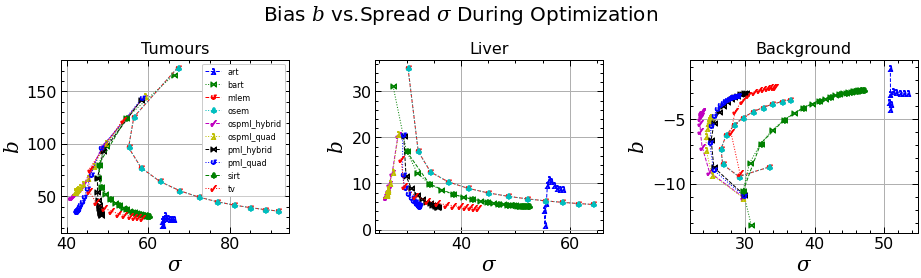

In [17]:
fig = plt.figure(figsize=(13,4))
plt.subplot(131)
[plt.plot(np.sqrt(df1[algo]['data']['T']['VAR'][1:]), df1[algo]['data']['T']['BIAS'][1:],
          marker=styles[i%len(styles)], color=colors[i%len(colors)], ls=linestyles[i%len(linestyles)], lw=1, label=algo) for i,algo in enumerate(algos)]
plt.xlabel('$\sigma$', fontsize=20)
plt.ylabel('$b$', fontsize=20)
plt.legend()
plt.title(r'Tumours')
plt.legend(ncol=1, fontsize=8, facecolor='white', framealpha=1, frameon=True, loc='upper right')
plt.grid()

plt.subplot(132)
[plt.plot(np.sqrt(df1[algo]['data']['L']['VAR'][1:]), df1[algo]['data']['L']['BIAS'][1:],
          marker=styles[i%len(styles)], color=colors[i%len(colors)], ls=linestyles[i%len(linestyles)], lw=1, label=algo) for i,algo in enumerate(algos)]
plt.xlabel('$\sigma$', fontsize=20)
plt.ylabel('$b$', fontsize=20)
plt.title(r'Liver')
plt.grid()

plt.subplot(133)
[plt.plot(np.sqrt(df1[algo]['data']['B']['VAR'][1:]), df1[algo]['data']['B']['BIAS'][1:],
          marker=styles[i%len(styles)], color=colors[i%len(colors)], ls=linestyles[i%len(linestyles)], lw=1, label=algo) for i,algo in enumerate(algos)]
plt.xlabel('$\sigma$', fontsize=20)
plt.ylabel('$b$', fontsize=20)
plt.title(r'Background')
plt.grid()

fig.suptitle('Bias $b$ vs.Spread $\sigma$ During Optimization', fontsize=20)
fig.tight_layout()
plt.show()

<ipython-input-18-28e4b36db41d>:2: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("plasma").copy()
  cmap.set_under(color='black')


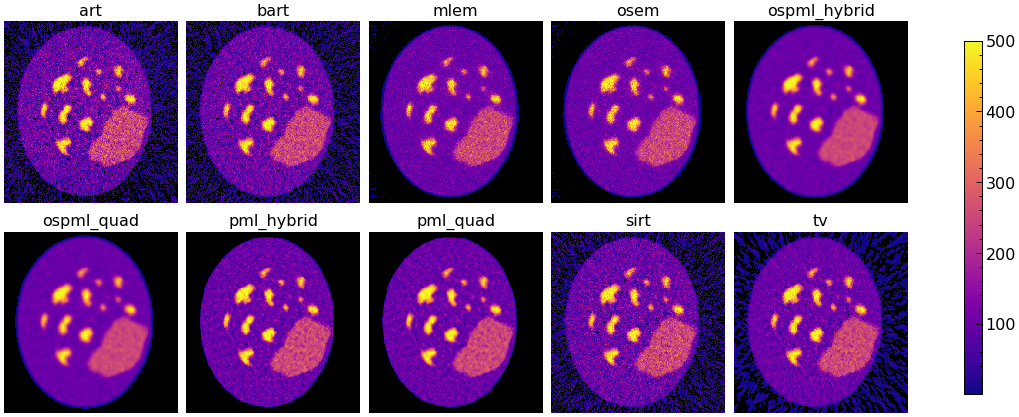

In [18]:
cmap = mpl.cm.get_cmap("plasma")
cmap.set_under(color='black')
fig, axes = plt.subplots(2,5,figsize=(16,6))
for i,algo in enumerate(algos):
    ax = axes.ravel()[i]
    ax.set_title(algo)
    pcm = ax.pcolormesh(df1[algo]['im_bests'][0], vmin=1, vmax=500, cmap=cmap)
    ax.set_axis_off()
fig.tight_layout()
fig.colorbar(pcm, ax=axes, shrink=0.9)
plt.savefig('images/recon.png', dpi=200)

In [19]:
for algo in df1.keys():
    np.savez("images/algo_images_P1/{}.npz".format(algo), img=df1[algo]['im_bests'][0])

Get pictures of all recon

In [13]:
algos = ['art', 'bart', 'mlem', 'osem', 'ospml_hybrid', 'ospml_quad', 'pml_hybrid', 'pml_quad', 'sirt', 'tv']
iterations = [10, 250, 60, 60, 200, 200, 140, 200, 300, 360]

lam = 500
n = 400

A = imageio.imread('images/phantom1.png').sum(axis=2)
A_norm = functions.normalize_phantom(A)
Ts = np.array([np.asarray(imageio.imread(f'images/t{i}.png').sum(axis=2) > 0) for i in range(1,24)])
T = Ts.sum(axis=0).astype(bool)
T_masked = np.ma.masked_where(~T, T)

U = functions.get_tumour_dist(T, sigma=3)

dfile = np.load('tumour_dist_P1.npz')
PET_og, dpoints, dangles, prob_of_detections = dfile['PET_og'], dfile['dpoints'], dfile['dangles'], dfile['prob_of_detections']

PET_att, mask_att = functions.get_attenuated_PET(dpoints, dangles, prob_of_detections, n=n)

sino, rs, thetas =  functions.get_sinogram(dpoints, dangles)
sino_att, _, _ =  functions.get_sinogram(dpoints, dangles, mask=mask_att)

det_matrix = functions.compute_detection_matrix(A_norm, n=400, spacing=4)

info = {}
for algo, iteration in zip(algos, iterations):
    print(algo)
    im = functions.compute_recon_tomopy(sino_att, thetas, algo, num_iter=iteration);
    im = im/det_matrix
    info[algo] = im

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\lukep\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3418, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-dcb1e30fbc4b>", line 23, in <module>
    det_matrix = functions.compute_detection_matrix(A_norm, n=400, spacing=4)
  File "C:\Users\lukep\Documents\videos\School\Phys 541\final_proj\functions.py", line 104, in compute_detection_matrix
    ps = np.vectorize(estimate_prob_of_detections, excluded=['A', 'thetas'])(xv, yv, A=A)
  File "C:\Users\lukep\anaconda3\lib\site-packages\numpy\lib\function_base.py", line 2163, in __call__
    return self._vectorize_call(func=func, args=vargs)
  File "C:\Users\lukep\anaconda3\lib\site-packages\numpy\lib\function_base.py", line 2246, in _vectorize_call
    outputs = ufunc(*inputs)
  File "C:\Users\lukep\anaconda3\lib\site-packages\numpy\lib\function_base.py", line 2158, in func
    return self.pyfunc(*the_args, **kwargs)
  File "C:\

TypeError: object of type 'NoneType' has no len()

<ipython-input-14-b6df6b52d0c4>:2: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("plasma").copy()
  cmap.set_under(color='black')


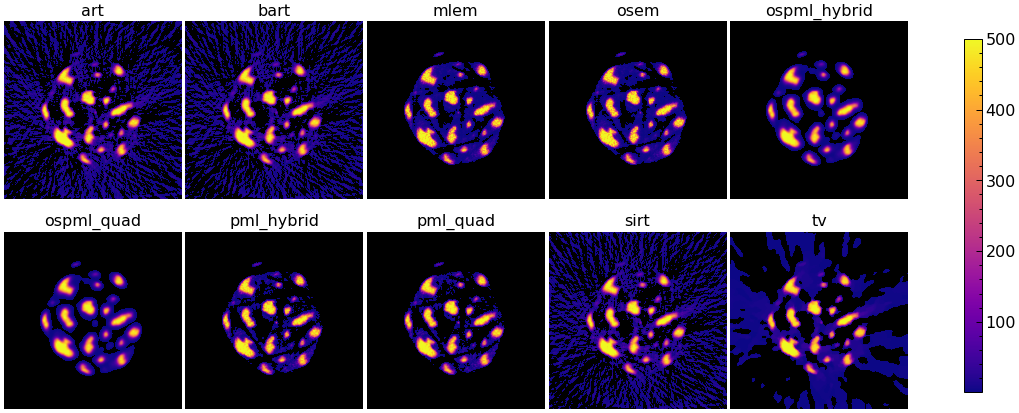

In [14]:
cmap = mpl.cm.get_cmap("plasma")
cmap.set_under(color='black')
fig, axes = plt.subplots(2,5,figsize=(16,6))
for i,algo in enumerate(algos):
    ax = axes.ravel()[i]
    ax.set_title(algo)
    pcm = ax.imshow(info[algo], vmin=1, vmax=500, cmap=cmap)
    ax.set_axis_off()
fig.tight_layout()
fig.colorbar(pcm, ax=axes, shrink=0.9)
plt.savefig('images/recon.png', dpi=200)

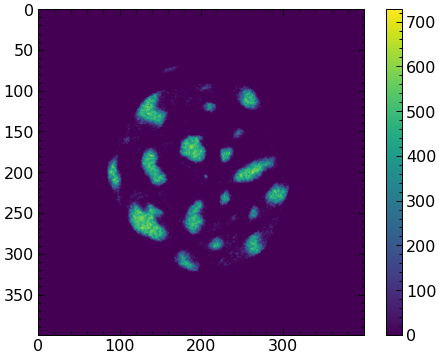

In [15]:
plt.imshow(info['pml_hybrid'])
plt.colorbar()

# Partial Volume Correction

In [99]:
import importlib
import paper_f_old as pfo 
import paper_f_newnew as pfn 
from skimage.restoration import denoise_nl_means, estimate_sigma, richardson_lucy, unsupervised_wiener, wiener
importlib.reload(pfo)
importlib.reload(pfn)

<module 'paper_f_newnew' from 'C:\\Users\\lukep\\Documents\\videos\\School\\Phys 541\\final_proj\\paper_f_newnew.py'>

Load one of the images from the last section

In [225]:
img = np.load('images/algo_images_P1/pml_quad.npz')['img']
img_nlm = denoise_nl_means(img, patch_size=10, patch_distance=30, h=30)

In [130]:
img_rl = richardson_lucy(img, get_gaus_kernel(9, 2.5), iterations=30, clip=False)

In [131]:
img_us = unsupervised_wiener(img, get_gaus_kernel(9, 2.5), clip=False)

In [132]:
img_w = wiener(img, get_gaus_kernel(9, 5), balance=10, clip=False)

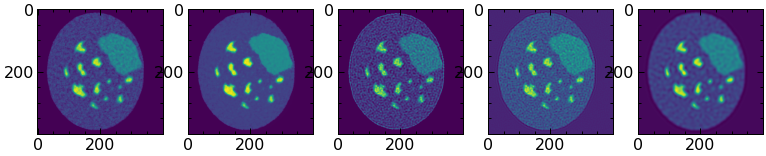

In [185]:
fig, ax = plt.subplots(1,5,figsize=(13,3))
ax[0].imshow(img)
ax[1].imshow(img_nlm)
ax[2].imshow(img_rl)
ax[3].imshow(img_us[0])
ax[4].imshow(img_w)

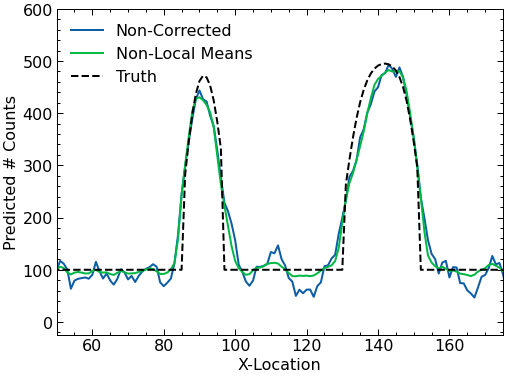

In [186]:
slc = 200
plt.plot(img[slc], label='Non-Corrected')
plt.plot(img_nlm[slc], label='Non-Local Means')
#plt.plot(img_us[0][slc])
#plt.plot(img_w[slc])
plt.plot(500*U[slc], ls='--', color='k', label='Truth')
plt.xlim(50,175)
plt.ylim(top=600)
plt.xlabel('X-Location')
plt.ylabel('Predicted # Counts')
plt.legend()

In [191]:
lam = U[T].ravel()*500 #original distribution
n_hat_raw = img[T]
n_hat_paper = img_us[0][T].ravel()

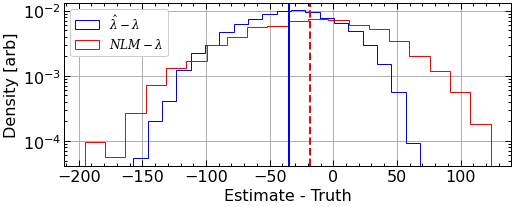

In [192]:
plt.figure(figsize=(8,3))
plt.hist(n_hat_raw-lam, color='blue', histtype='step', bins=20, label='$\hat{\lambda}-\lambda$', density=True)
plt.hist(n_hat_paper-lam, color='red', histtype='step', bins=20, label='$NLM-\lambda$', density=True)
plt.axvline(np.mean(n_hat_raw-lam), color='blue')
plt.axvline(np.mean(n_hat_paper-lam), color='red', ls='--')
plt.legend(ncol=1, fontsize=12, facecolor='white', framealpha=1, frameon=True, loc='upper left')
plt.xlabel('Estimate - Truth')
plt.ylabel('Density [arb]')
plt.grid()
plt.semilogy()
plt.show()

In [195]:
img_w = wiener(img, get_gaus_kernel(9, 5), balance=10, clip=False)

In [226]:
for name, A in zip(['tumour', 'liver', 'background'], [T, L, B]):
    lam = U[A].ravel()*500 #original distribution
    n_hat_raw = img[A]
    n_hat_paper = img_nlm[A].ravel()
    print('')
    print(name)
    print('---')
    print('Sigma')
    print(f'Original: {np.std(n_hat_raw-lam)}, New: {np.std(n_hat_paper-lam)}')
    print('Bias')
    print(f'Original: {np.mean(n_hat_raw-lam)}, New: {np.mean(n_hat_paper-lam)}')
    print('RMSE')
    print(f'Original: {np.sqrt(np.mean((n_hat_raw-lam)**2))}, New: {np.sqrt(np.mean((n_hat_paper-lam)**2))}')


tumour
---
Sigma
Original: 37.51867860248074, New: 35.33896717960123
Bias
Original: -34.515654316724266, New: -37.713908477942816
RMSE
Original: 50.98020828701912, New: 51.68347408992143

liver
---
Sigma
Original: 28.163143074197873, New: 16.636876816298
Bias
Original: -5.223908992696661, New: -5.399863094135901
RMSE
Original: 28.64353073525882, New: 17.49126043588868

background
---
Sigma
Original: 27.299257634184904, New: 18.128929505545475
Bias
Original: 3.2310001121733616, New: 2.6288837299351426
RMSE
Original: 27.489794999280498, New: 18.318545648674046


Find out which Wiener params are best

In [211]:
balances = np.linspace(1,50,30)
rmses = []
for balance in balances:
    img_w = wiener(img, get_gaus_kernel(9, 5), balance=balance, clip=False)
    lam = U[A].ravel()*500 #original distribution
    n_hat_raw = img[A]
    n_hat_paper = img_w[A].ravel()
    rmses.append(np.sqrt(np.mean((n_hat_paper-lam)**2)))
balances = np.array(balances)
rmses = np.array(rmses)

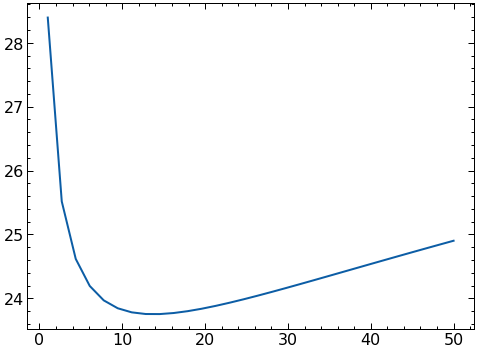

In [212]:
plt.plot(balances, rmses)

In [213]:
balances[np.argmin(rmses)]

14.517241379310345

In [222]:
stds = np.linspace(0.1,0.5,20)
rmses = []
for std in stds:
    img_w = wiener(img, get_gaus_kernel(9, std), balance=14.5, clip=False)
    lam = U[A].ravel()*500 #original distribution
    n_hat_raw = img[A]
    n_hat_paper = img_w[A].ravel()
    rmses.append(np.sqrt(np.mean((n_hat_paper-lam)**2)))
stds = np.array(stds)
rmses = np.array(rmses)

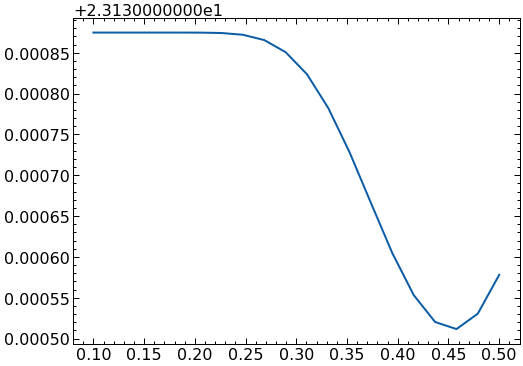

In [223]:
plt.plot(stds, rmses)

* Initial image `i` is the image from above but smoothed
* MRI image `l` is 1 inside tumours and 0 outside tumours
* `h` is the estimated point spread function (PSF) of the imaging device (reconstruction)
* `o` is the initial guess, and it will be optimized

In [23]:
l = T.astype(float) + L_val*L.astype(float)+B_val*B.astype(float)

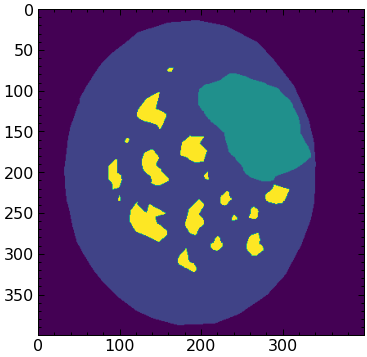

In [24]:
plt.imshow(l)

In [30]:
i = gaussian(img, sigma=2)
l = T.astype(float)
h = get_gaus_kernel(9, 2.5)
o = i.copy().ravel()

Get gradient

In [14]:
lam = 0.5
lam2 = 3

In [15]:
lam = 1
lam2 = 3

Loss function originally was

$$J(o) = \sum_r \left(\hat{\lambda}(r) -o(r) \otimes h(r) \right)^2 + \alpha_1 \sum_r \sum_{k \in N(r)} \frac{w_{rk}}{d_{rk}}\left(o(r) - o(k) \right)^2 + \alpha_2 \sum_r e^{-\kappa l(r)} o(r)^2$$

modifed to make it

* $w_{rk}$ depends on if I'm using the papers definition or my definition (my definition requires **1 parameter**)
* $\alpha_1$ and $\alpha_2$ constitute **two parameters**.
* $\kappa$ is **another parameter**.

Thus there are **4 parameters total**.


Test to make sure $dJ/do(r)$ is defined correctly inside functions:

In [16]:
o_test = o.copy()
do = 0.000001
o_test[47735]+=do
print((pfn.f(o_test, i, l, h, lam, lam2) - pfn.f(o,i,l,h, lam, lam2))/do)
grad = pfn.gradf(o,i,l,h, lam, lam2)
print(grad[47735])

38.95163536071777
38.916408097463446


Look at a plot of the gradient:

In [17]:
grad_samp = pfn.gradf(o, i, l, h, lam, lam2)
grad_samp = grad_samp.reshape(400,400)

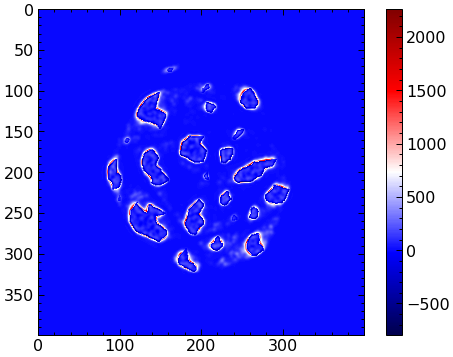

In [18]:
cmap = mpl.cm.get_cmap("seismic")
plt.imshow(grad_samp, cmap=cmap)
plt.colorbar()

Optimize.

* **Case 1**: `lam2=0`: corresponds to $\alpha_2=0$ in loss function above (no leakage control)
* **Case 2**: Everything as is should be

In [19]:
res_1 = optimize.minimize(pfn.f,o,args=(i,l,h,lam,0), jac=pfn.gradf, method='CG',
                       options=dict(maxiter=100, gtol=160000*1e-5))

res_2 = optimize.minimize(pfn.f,o,args=(i,l,h,lam, lam2), jac=pfn.gradf, method='CG',
                       options=dict(maxiter=100, gtol=160000*1e-5))

Look at all the images

<ipython-input-20-45963e1af0f3>:2: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("plasma").copy()
  cmap.set_under(color='black')


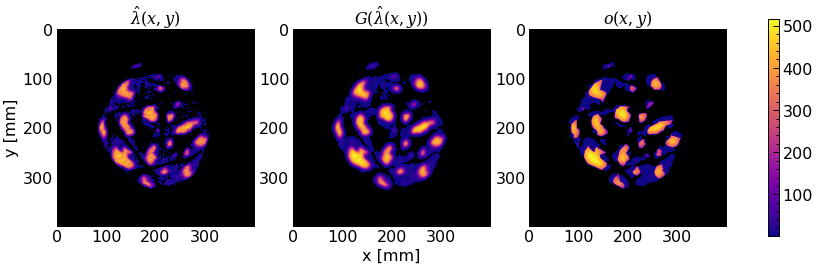

In [20]:
cmap = mpl.cm.get_cmap("plasma")
cmap.set_under(color='black')
fig, axes = plt.subplots(1,3,figsize=(15,8))
axes[0].imshow(img, vmin=1, cmap=cmap)
axes[0].set_title('$\hat{\lambda}(x,y)}$')
axes[0].set_ylabel('y [mm]')
axes[1].imshow(i.reshape(400,400), vmin=1, cmap=cmap)
axes[1].set_title('$G(\hat{\lambda}(x,y))$')
axes[1].set_xlabel('x [mm]')
pcm = axes[2].imshow(res_2.x.reshape(400,400), vmin=1, cmap=cmap)
axes[2].set_title('$o(x,y)})$')
#[a.set_axis_off() for a in axes]
fig.colorbar(pcm, ax=axes, shrink=0.5)
plt.savefig('images/PVC_chain.png', dpi=200)

Look at some sample slices in the image

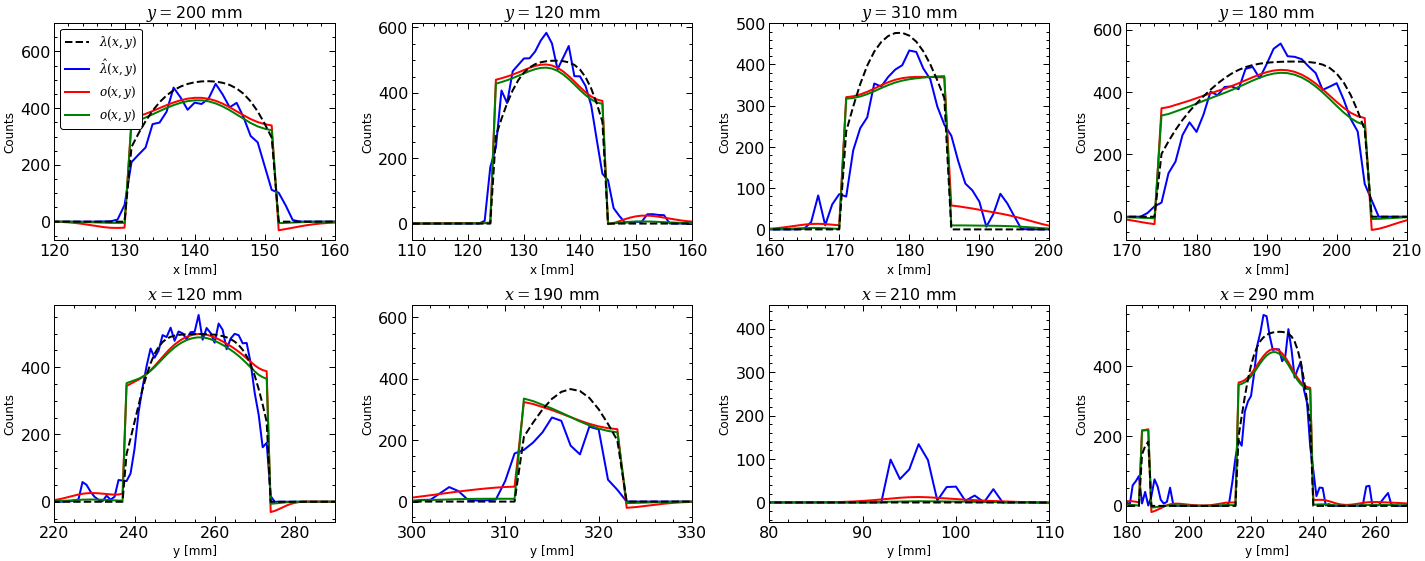

In [21]:
slics = [200,120,310,180,120,190,210,290]
rngs = [(120,160),(110,160),(160,200),(170,210),(220,290),(300,330),(80,110),(180,270)]
fig, ax = plt.subplots(2,4,figsize=(20,8))
for i, (slic, rng) in enumerate(zip(slics, rngs)):
    a = ax.ravel()[i]
    if i<4:
        a.plot(500*U[slic], ls='--', color='k', label='$\lambda(x,y)$', zorder=1000)
        a.plot(img[slic], label='$\hat{\lambda}(x,y)$', color='blue')
        a.plot(res_1.x.reshape(400,400)[slic], label='$o(x,y)$', color='red')
        a.plot(res_2.x.reshape(400,400)[slic], label='$o(x,y)$', color='green')
        a.set_xlabel('x [mm]', fontsize=12)
        a.set_ylabel('Counts', fontsize=12)
        a.set_title('$y=${} mm'.format(slic))
    elif i>=4:
        a.plot(500*U[:,slic], ls='--', color='k', label='$\lambda(x,y)$', zorder=1000)
        a.plot(img[:,slic], label='$\hat{\lambda}(x,y)$', color='blue')
        a.plot(res_1.x.reshape(400,400)[:,slic], label='$o(x,y)$', color='red')  
        a.plot(res_2.x.reshape(400,400)[:,slic], label='$o(x,y)$', color='green')  
        
        a.set_xlabel('y [mm]', fontsize=12)
        a.set_ylabel('Counts', fontsize=12)
        a.set_title('$x=${} mm'.format(slic))
        
        
    a.set_xlim(rng)
ax[0,0].legend(loc='upper left', fontsize=12, facecolor='white', framealpha=1, frameon=True, edgecolor='k')
ax[0,0].set_ylim(top=700)
fig.tight_layout()
plt.savefig('images/pvc_results.png', dpi=200)

Compare everything to the original distribution:
* Only index at points `T` (these are tumour locations)

In [49]:
lam = U[T].ravel()*500 #original distribution
n_hat_raw = gaussian(img, sigma=2)[T].ravel()
n_hat_raw = img[T]
n_hat_paper = res_2.x.reshape(400,400)[T].ravel()

Plot

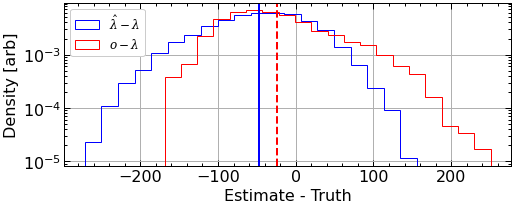

In [50]:
plt.figure(figsize=(8,3))
plt.hist(n_hat_raw-lam, color='blue', histtype='step', bins=20, label='$\hat{\lambda}-\lambda$', density=True)
plt.hist(n_hat_paper-lam, color='red', histtype='step', bins=20, label='$o-\lambda$', density=True)
plt.axvline(np.mean(n_hat_raw-lam), color='blue')
plt.axvline(np.mean(n_hat_paper-lam), color='red', ls='--')
plt.legend(ncol=1, fontsize=12, facecolor='white', framealpha=1, frameon=True, loc='upper left')
plt.xlabel('Estimate - Truth')
plt.ylabel('Density [arb]')
plt.grid()
plt.semilogy()
plt.savefig('images/PVC_hist.png', dpi=200)
plt.show()

RMSEs:

In [51]:
np.sqrt(np.mean((n_hat_raw-lam)**2))

79.26478196150167

In [52]:
np.sqrt(np.mean((n_hat_paper-lam)**2))

69.51090985326604

Look at some SUV metrics:

In [53]:
def compute_SUV_max(PET_og, PET_recon_filtered, Ts):
    SUV_og = []
    SUV_recon_filtered = []
    tumour_size = []
    for T in Ts:
        tumour_size.append(T.sum())
        SUV_og.append(PET_og[T].max())
        SUV_recon_filtered.append(PET_recon_filtered[T].max())
    return np.array(tumour_size), np.array(SUV_og), np.array(SUV_recon_filtered)

def compute_SUV_mean(PET_og, PET_recon_filtered, Ts):
    SUV_og = []
    SUV_recon_filtered = []
    tumour_size = []
    for T in Ts:
        tumour_size.append(T.sum())
        SUV_og.append(PET_og[T].mean())
        SUV_recon_filtered.append(PET_recon_filtered[T].mean())
    return np.array(tumour_size), np.array(SUV_og), np.array(SUV_recon_filtered)

Plot

In [54]:
tumour_size, SUV_og_max_i, SUV_recon_max_i = compute_SUV_max(PET_og, img, Ts)
tumour_size, SUV_og_mean_i, SUV_recon_mean_i = compute_SUV_mean(PET_og, img, Ts)
tumour_size, SUV_og_max, SUV_recon_max = compute_SUV_max(PET_og, res_2.x.reshape(400,400), Ts)
tumour_size, SUV_og_mean, SUV_recon_mean = compute_SUV_mean(PET_og, res_2.x.reshape(400,400), Ts)

In [55]:
pct_max_lam = 100*np.abs(SUV_og_max - SUV_recon_max_i)/SUV_og_max
pct_mean_lam = 100*np.abs(SUV_og_mean - SUV_recon_mean_i)/SUV_og_max
pct_max_o = 100*np.abs(SUV_og_max - SUV_recon_max)/SUV_og_max
pct_mean_o = 100*np.abs(SUV_og_mean - SUV_recon_mean)/SUV_og_max

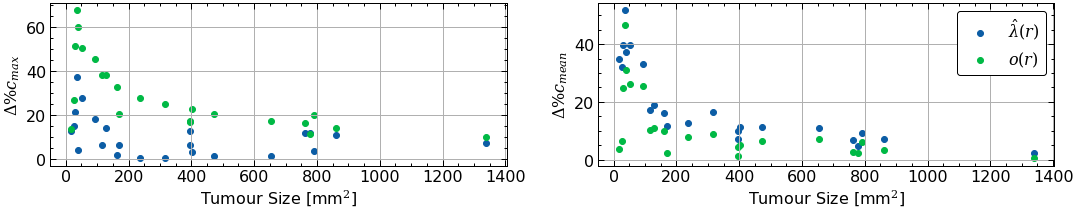

In [56]:
fig, ax = plt.subplots(1,2,figsize=(18,3))
ax[0].scatter(tumour_size, pct_max_lam, label='$\hat{\lambda}(r)$')
ax[0].scatter(tumour_size, pct_max_o, label='$o(r)$')
ax[1].scatter(tumour_size, pct_mean_lam, label='$\hat{\lambda}(r)$')
ax[1].scatter(tumour_size, pct_mean_o, label='$o(r)$')
ax[0].set_xlabel('Tumour Size [mm$^2$]')
ax[1].set_xlabel('Tumour Size [mm$^2$]')
ax[0].set_ylabel(r'$\Delta \%c_{max}$')
ax[1].set_ylabel(r'$\Delta \%c_{mean}$')
ax[0].grid()
ax[1].grid()
ax[1].legend(loc='upper right', fontsize=16, facecolor='white', framealpha=1, frameon=True, edgecolor='k')
plt.savefig('images/suv.png', dpi=200)
plt.show()

Look at the differences between $c_{mean}$ and $c_{max}$ for $\hat{\lambda}$ and $o$.

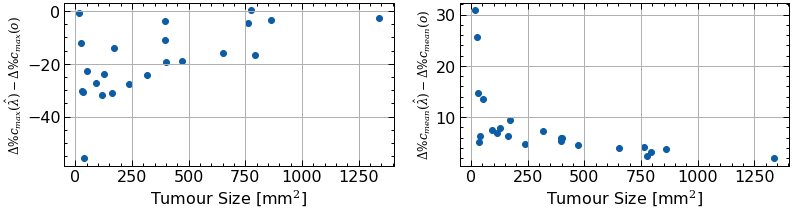

In [57]:
fig, ax = plt.subplots(1,2,figsize=(13,3))
ax[0].scatter(tumour_size, pct_max_lam-pct_max_o)
ax[1].scatter(tumour_size, pct_mean_lam-pct_mean_o)
ax[0].set_xlabel('Tumour Size [mm$^2$]')
ax[1].set_xlabel('Tumour Size [mm$^2$]')
ax[0].set_ylabel(r'$\Delta \%c_{max} (\hat{\lambda}) - \Delta \%c_{max} (o)$', fontsize=12)
ax[1].set_ylabel(r'$\Delta \%c_{mean} (\hat{\lambda}) - \Delta \%c_{mean} (o)$', fontsize=12)
ax[0].grid()
ax[1].grid()
plt.show()

# Analyzing all PVC images

In [60]:
lam = U[T].ravel()*500 #original distribution

In [79]:
imgs = {}
rmses = {}
biass = {}
varss = {}
for algo in ['art', 'bart', 'mlem', 'osem', 'ospml_hybrid', 'ospml_quad', 'pml_hybrid', 'pml_quad', 'sirt', 'tv']:
    
    img_raw = np.load('images/algo_images_P1/{}.npz'.format(algo))['img']
    img_paper = np.load('images/algo_images_P1/PVC/{}.npz'.format(algo))['img']
    
    n_hat_raw = img_raw[T]
    n_hat_paper = img_paper[T]
    rmses[algo] = {'Raw': np.sqrt(np.mean((n_hat_raw-lam)**2)),
                   'PVC': np.sqrt(np.mean((n_hat_paper-lam)**2))}
    varss[algo] = {'Raw': np.var(n_hat_raw-lam),
                   'PVC': np.var(n_hat_paper-lam)}
    biass[algo] = {'Raw': np.mean(n_hat_raw-lam),
                   'PVC': np.mean(n_hat_paper-lam)}

In [95]:
rmses

{'art': {'Raw': 75.2669288038482, 'PVC': 67.56795842781227},
 'bart': {'Raw': 73.9988478771766, 'PVC': 69.02225369129512},
 'mlem': {'Raw': 132.7470797991379, 'PVC': 70.53681384631334},
 'osem': {'Raw': 132.7470797991379, 'PVC': 70.53681384631334},
 'ospml_hybrid': {'Raw': 82.33306538559927, 'PVC': 76.73038167328404},
 'ospml_quad': {'Raw': 84.3061988239741, 'PVC': 78.39705860731533},
 'pml_hybrid': {'Raw': 88.16356495487041, 'PVC': 69.51396442151024},
 'pml_quad': {'Raw': 79.26478196150167, 'PVC': 69.51090985326604},
 'sirt': {'Raw': 73.9898871027546, 'PVC': 68.79791598521749},
 'tv': {'Raw': 70.72908448441471, 'PVC': 69.85767947814765}}

In [96]:
pct_dffs_rmse

array([-10.2288887 ,  -6.72523198, -46.86375478, -46.86375478,
        -6.80490115,  -7.00914085, -21.15341019, -12.30542981,
        -7.01713615,  -1.23203207])

In [83]:
rmses_raw = np.array([rmses[key]['Raw'] for key in rmses.keys()])
rmses_pvc = np.array([rmses[key]['PVC'] for key in rmses.keys()])

vars_raw = np.array([varss[key]['Raw'] for key in rmses.keys()])
vars_pvc = np.array([varss[key]['PVC'] for key in rmses.keys()])

bias_raw = np.array([biass[key]['Raw'] for key in rmses.keys()])
bias_pvc = np.array([biass[key]['PVC'] for key in rmses.keys()])

In [90]:
pct_dffs_rmse = 100*(rmses_pvc - rmses_raw)/rmses_raw
pct_dffs_var = 100*(vars_pvc - vars_raw)/vars_raw
pct_dffs_bias = 100*(bias_pvc - bias_raw)/bias_raw

In [91]:
np.mean(pct_dffs_rmse)

-16.620368046407123

In [92]:
np.mean(pct_dffs_var)

11.018131663757845

In [93]:
np.mean(pct_dffs_bias)

-52.45872017342587